# Convolutional Neural Networks for digit image classification

The popular [MNIST](https://en.wikipedia.org/wiki/MNIST_database) handwritten digit image classification dataset contains 60′000 + 10′000 hand- written digits to be classified as a number between 0 and 9.

The sequence of (more and more complex) models defined below will eventually arrive at the one suggested in this [tutorial](https://machinelearningmastery.com/tensorflow-tutorial-deep-learning-with-tf-keras/).

## Steps

1. Loading and plotting the mnist dataset
2. Setting the sceene for image classification 
3. Defining and evaluating the baseline model 
4. Adding Pooling
5. Adding a CNN Kernel
6. Adding another dense output layer

## Loading and plotting the MNIST dataset

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


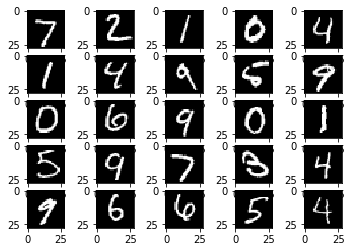

In [6]:
from tensorflow.keras.datasets.mnist import load_data 
from matplotlib import pyplot

# load dataset
(x_train, y_train), (x_test, y_test) = load_data()

# summarize loaded dataset
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape)) 
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

# plot first few images
for i in range(25):
    # define subplot
    pyplot.subplot(5, 5, i+1)
    # plot raw pixel data
    pyplot.imshow(x_test[i], cmap=pyplot.get_cmap('gray'))

# show the figure
pyplot.show()

## Setting the sceene for image classification

Fix necessary imports.

In [7]:
from numpy import zeros
from numpy import unique
from numpy import argmax
from numpy import asarray
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.metrics import Accuracy

Reshape data to have a single b/w channel.

In [8]:
orig_shape = x_train.shape[1:]
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
in_shape = x_train.shape[1:]
print("Before: {0}".format(orig_shape))
print("After: {0}".format(in_shape))

Before: (28, 28)
After: (28, 28, 1)


Determine the number of classes.

In [9]:
n_classes = len(unique(y_train)) 
print("Classes: {0}".format(n_classes))

Classes: 10


Normalize pixel values `int[0..255]` $\rightarrow$ `float32[0..1]`.

In [10]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

Function to define the CNN model architecture and compile it with constant surrogate goal function (loss), evaluation metrics, and optimizer. We will vary depth, kernel_width, and pool_stride of the models.

In [11]:
def make_model(depth, kernel_width, pool_stride, add_dense=False):
    model = Sequential()
    model.add(Conv2D(depth, (kernel_width,kernel_width), activation='relu',input_shape=in_shape))
    model.add(MaxPool2D((pool_stride, pool_stride)))
    model.add(Flatten())
    if add_dense:
        model.add(Dense(100, activation='relu'))
        model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax')) 
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model

Define learning parameters for all models.

In [45]:
EPOCHS = 10
BATCH_SIZE = 128
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    verbose=1,
    patience=10,
    mode='max', 
    restore_best_weights=True)
it = round(60000/BATCH_SIZE)

It takes {{it}} iterations to finish an epch.

Function to show the history of training.

In [13]:
def plot_metrics(history):
    colors = pyplot.rcParams['axes.prop_cycle'].by_key()['color'] 
    metrics = ['loss', 'accuracy'] 
    pyplot.figure(figsize=(10,5))
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        pyplot.subplot(1,2,n+1)
        pyplot.plot(history.epoch, history.history[metric], color=colors[0],label='Train')
        pyplot.plot(history.epoch, history.history['val_'+ metric],color=colors[0], linestyle="--", label='Val') 
        pyplot.xlabel('Epoch')
        pyplot.ylabel(name)
        if metric == 'loss':
            pyplot.ylim([0, pyplot.ylim()[1] +0.1]) 
        else:
            pyplot.ylim([-0.1,1.1])
        pyplot.legend()

## Baseline

We set `depth=1`, `kernel_width=1x1`, and `pool_stride=1`, i.e., no effective CNN.

In [14]:
baseline = make_model(1,1,1)
baseline.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 1)         2         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 1)         0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7850      
Total params: 7,852
Trainable params: 7,852
Non-trainable params: 0
_________________________________________________________________


Note that the kernel has one weight and one bias, i.e., `Param = 2` for the CNN layer. The output of the CNN and the pooling layers are equal to their inputs.

We train the baseline model.

In [15]:
baseline_history = baseline.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE)

Epoch 1/10
469/469 [==============================] - 4s 8ms/step - loss: 2.3019 - accuracy: 0.1087 - val_loss: 2.3011 - val_accuracy: 0.1135
Epoch 2/10
469/469 [==============================] - 3s 6ms/step - loss: 2.3014 - accuracy: 0.1118 - val_loss: 2.3010 - val_accuracy: 0.1135
Epoch 3/10
469/469 [==============================] - 3s 6ms/step - loss: 2.3012 - accuracy: 0.1141 - val_loss: 2.3010 - val_accuracy: 0.1135
Epoch 4/10
469/469 [==============================] - 3s 6ms/step - loss: 2.3013 - accuracy: 0.1102 - val_loss: 2.3010 - val_accuracy: 0.1135
Epoch 5/10
469/469 [==============================] - 3s 6ms/step - loss: 2.3013 - accuracy: 0.1094 - val_loss: 2.3010 - val_accuracy: 0.1135
Epoch 6/10
469/469 [==============================] - 3s 6ms/step - loss: 2.3012 - accuracy: 0.1123 - val_loss: 2.3010 - val_accuracy: 0.1135
Epoch 7/10
469/469 [==============================] - 3s 7ms/step - loss: 2.3012 - accuracy: 0.1107 - val_loss: 2.3010 - val_accuracy: 0.1135
Epoch 

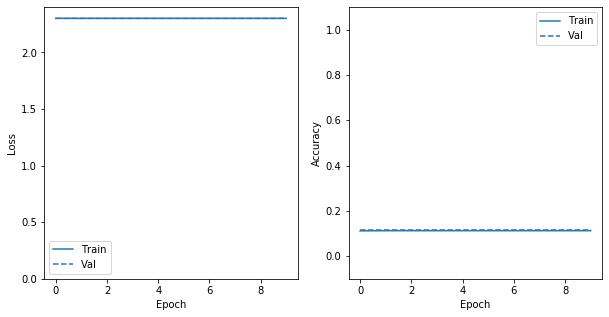

In [16]:
plot_metrics(baseline_history)

We evaluate the trained model.

In [17]:
loss, acc = baseline.evaluate(x_test, y_test, verbose=0) 
print('Accuracy: %.3f' % acc)

Accuracy: 0.113


Use the model to make a prediction.

In [18]:
xx = x_test[9]
xxx = asarray([xx])
yhat = baseline.predict(xxx)
argmax(yhat)

1

In [19]:
def print_res(model): 
    err = 0
    i_range = 10
    ys = zeros(i_range * i_range) 
    class bcolors:
        FAIL = '\033[91m'
        ENDC = '\033[0m' 
    for i in range(10):
        for j in range(i_range):
            idx = i*i_range+j
            image = x_test[idx]
            yhat = model.predict(asarray([image]))
            ys[idx] = argmax(yhat) 
            print('%d ' % ys[idx], end = '')
        print()
    print("--")
    for i in range(i_range): 
        for j in range(i_range):
            idx = i*i_range+j; 
            y = y_test[idx] 
            if y==ys[idx]:
                print('%d ' % y, end = '')
            else:
                err = err + 1
                print(f"{bcolors.FAIL}%d {bcolors.ENDC}" % y, end = '') 
        print()
    return err

In [20]:
print_res(baseline)

1 1 1 1 1 1 1 1 1 1 
1 1 1 1 1 1 1 1 1 1 
1 1 1 1 1 1 1 1 1 1 
1 1 1 1 1 1 1 1 1 1 
1 1 1 1 1 1 1 1 1 1 
1 1 1 1 1 1 1 1 1 1 
1 1 1 1 1 1 1 1 1 1 
1 1 1 1 1 1 1 1 1 1 
1 1 1 1 1 1 1 1 1 1 
1 1 1 1 1 1 1 1 1 1 
--
7 2 1 0 4 1 4 9 5 9 
0 6 9 0 1 5 9 7 3 4 
9 6 6 5 4 0 7 4 0 1 
3 1 3 4 7 2 7 1 2 1 
1 7 4 2 3 5 1 2 4 4 
6 3 5 5 6 0 4 1 9 5 
7 8 9 3 7 4 6 4 3 0 
7 0 2 9 1 7 3 2 9 7 
7 6 2 7 8 4 7 3 6 1 
3 6 9 3 1 4 1 7 6 9 


86

There are 5 mistatakes in the first 100 images. The classic dense layer does quite good already.

## Adding Pooling

We set `depth=1`, `kernel_width=1x1`, and `pool_stride=2`, i.e., no effective CNN and we even squeeze the image size.

In [21]:
model1 = make_model(1,1,2, False)
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 1)         2         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 196)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1970      
Total params: 1,972
Trainable params: 1,972
Non-trainable params: 0
_________________________________________________________________


The kernel has still one weight and one bias, i.e., `Param = 2` for the CNN layer. The output of the pooling layers is one quater (half in each dimension) of the CNN in- and output.

We train the first CNN model.

In [22]:
model1_history = model1.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE)

Epoch 1/10
469/469 [==============================] - 3s 5ms/step - loss: 2.3020 - accuracy: 0.1104 - val_loss: 2.3010 - val_accuracy: 0.1135
Epoch 2/10
469/469 [==============================] - 2s 5ms/step - loss: 2.3012 - accuracy: 0.1124 - val_loss: 2.3010 - val_accuracy: 0.1135
Epoch 3/10
469/469 [==============================] - 2s 5ms/step - loss: 2.3015 - accuracy: 0.1108 - val_loss: 2.3011 - val_accuracy: 0.1135
Epoch 4/10
469/469 [==============================] - 2s 5ms/step - loss: 2.3007 - accuracy: 0.1135 - val_loss: 2.3011 - val_accuracy: 0.1135
Epoch 5/10
469/469 [==============================] - 2s 5ms/step - loss: 2.3009 - accuracy: 0.1133 - val_loss: 2.3010 - val_accuracy: 0.1135
Epoch 6/10
469/469 [==============================] - 2s 5ms/step - loss: 2.3013 - accuracy: 0.1119 - val_loss: 2.3010 - val_accuracy: 0.1135
Epoch 7/10
469/469 [==============================] - 2s 5ms/step - loss: 2.3013 - accuracy: 0.1118 - val_loss: 2.3010 - val_accuracy: 0.1135
Epoch 

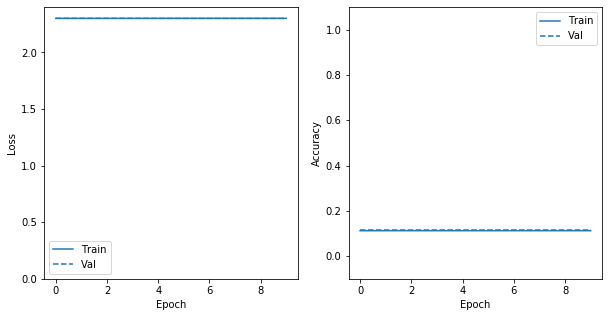

In [23]:
plot_metrics(model1_history)

We evaluate the trained model.

In [24]:
loss, acc = model1.evaluate(x_test, y_test, verbose=0) 
print('Accuracy: %.3f' % acc)

Accuracy: 0.113


Gets worse. Use the model to make a prediction.

In [25]:
print_res(model1)

1 1 1 1 1 1 1 1 1 1 
1 1 1 1 1 1 1 1 1 1 
1 1 1 1 1 1 1 1 1 1 
1 1 1 1 1 1 1 1 1 1 
1 1 1 1 1 1 1 1 1 1 
1 1 1 1 1 1 1 1 1 1 
1 1 1 1 1 1 1 1 1 1 
1 1 1 1 1 1 1 1 1 1 
1 1 1 1 1 1 1 1 1 1 
1 1 1 1 1 1 1 1 1 1 
--
7 2 1 0 4 1 4 9 5 9 
0 6 9 0 1 5 9 7 3 4 
9 6 6 5 4 0 7 4 0 1 
3 1 3 4 7 2 7 1 2 1 
1 7 4 2 3 5 1 2 4 4 
6 3 5 5 6 0 4 1 9 5 
7 8 9 3 7 4 6 4 3 0 
7 0 2 9 1 7 3 2 9 7 
7 6 2 7 8 4 7 3 6 1 
3 6 9 3 1 4 1 7 6 9 


86

No surprise that the accuracy drops and that there are more mistatakes 6 in the first 100 images.

## Adding a CNN Kernel

In [26]:
model2 = make_model(1,3,2)
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 1)         10        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 1)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 169)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1700      
Total params: 1,710
Trainable params: 1,710
Non-trainable params: 0
_________________________________________________________________


The kernel has still 3 × 3 weights and one bias, i.e., `Param = 10` for the CNN layer. No padding is applied, so the CNN layer ‘eats’ one pixel at the corners, i.e., its output shape is `(26, 26, 1)`. The output of the pooling layers is one quater (half in x and y dimension) of the CNN output.

We train the first real CNN model.

In [27]:
model2_history = model2.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE)

Epoch 1/10
469/469 [==============================] - 4s 7ms/step - loss: 1.6590 - accuracy: 0.4697 - val_loss: 0.3976 - val_accuracy: 0.8886
Epoch 2/10
469/469 [==============================] - 3s 7ms/step - loss: 0.3928 - accuracy: 0.8864 - val_loss: 0.3242 - val_accuracy: 0.9083
Epoch 3/10
469/469 [==============================] - 3s 7ms/step - loss: 0.3391 - accuracy: 0.9011 - val_loss: 0.3025 - val_accuracy: 0.9121
Epoch 4/10
469/469 [==============================] - 3s 7ms/step - loss: 0.3136 - accuracy: 0.9107 - val_loss: 0.2913 - val_accuracy: 0.9165
Epoch 5/10
469/469 [==============================] - 3s 7ms/step - loss: 0.3051 - accuracy: 0.9113 - val_loss: 0.2863 - val_accuracy: 0.9186
Epoch 6/10
469/469 [==============================] - 3s 7ms/step - loss: 0.2916 - accuracy: 0.9147 - val_loss: 0.2800 - val_accuracy: 0.9194
Epoch 7/10
469/469 [==============================] - 3s 7ms/step - loss: 0.2934 - accuracy: 0.9149 - val_loss: 0.2796 - val_accuracy: 0.9194
Epoch 

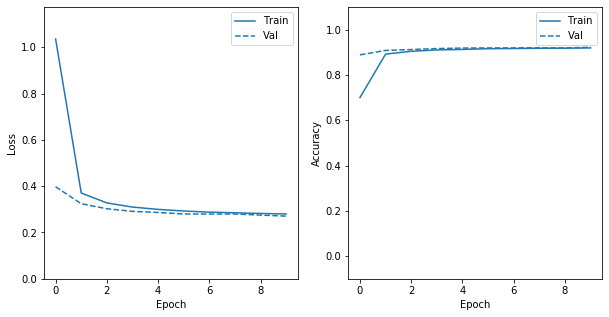

In [28]:
plot_metrics(model2_history)

We evaluate the trained model.

In [29]:
loss, acc = model2.evaluate(x_test, y_test, verbose=0) 
print('Accuracy: %.3f' % acc)

Accuracy: 0.922


Use the model to make a prediction.

In [30]:
print_res(model2)

7 2 1 0 4 1 4 9 6 9 
0 6 9 0 1 5 9 7 3 4 
9 6 6 5 4 0 7 4 0 1 
3 1 3 6 7 2 7 1 2 1 
1 7 4 2 3 5 1 2 4 4 
6 3 5 5 6 0 4 1 9 5 
7 8 9 2 7 4 6 4 3 0 
7 0 2 9 1 7 3 2 9 7 
7 6 2 7 8 4 7 3 6 1 
3 6 4 3 1 4 1 7 6 9 
--
7 2 1 0 4 1 4 9 5 9 
0 6 9 0 1 5 9 7 3 4 
9 6 6 5 4 0 7 4 0 1 
3 1 3 4 7 2 7 1 2 1 
1 7 4 2 3 5 1 2 4 4 
6 3 5 5 6 0 4 1 9 5 
7 8 9 3 7 4 6 4 3 0 
7 0 2 9 1 7 3 2 9 7 
7 6 2 7 8 4 7 3 6 1 
3 6 9 3 1 4 1 7 6 9 


4

The accuracy and the number of mistatakes (5) in the first 100 images is (almost) on par with the baseline model.

## Adding Parallel CNN Kernels

We set `depth=32`, and keep `kernel_width=3x3`, and `pool_stride=2`.

In [31]:
model3 = make_model(32,3,2)
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                54090     
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________


There are 32 kernels has each with 3 × 3 weights and one bias, i.e., `Param = 320` for the CNN layer. As no padding is applied, the CNN layer’s output shape is the same for the x and y dimensions , but it add depth: `(26, 26, 32)`. The output of the pooling layers is one quater (half in x and y dimension) of the CNN output, but it keeps the depth.

We train the first CNN model.

In [32]:
model3_history = model3.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE)

Epoch 1/10
469/469 [==============================] - 6s 13ms/step - loss: 0.6451 - accuracy: 0.8257 - val_loss: 0.1396 - val_accuracy: 0.9612
Epoch 2/10
469/469 [==============================] - 6s 14ms/step - loss: 0.1293 - accuracy: 0.9641 - val_loss: 0.0910 - val_accuracy: 0.9736
Epoch 3/10
469/469 [==============================] - 6s 14ms/step - loss: 0.0884 - accuracy: 0.9760 - val_loss: 0.0716 - val_accuracy: 0.9780
Epoch 4/10
469/469 [==============================] - 7s 14ms/step - loss: 0.0687 - accuracy: 0.9807 - val_loss: 0.0640 - val_accuracy: 0.9810
Epoch 5/10
469/469 [==============================] - 7s 16ms/step - loss: 0.0602 - accuracy: 0.9821 - val_loss: 0.0571 - val_accuracy: 0.9820
Epoch 6/10
469/469 [==============================] - 7s 16ms/step - loss: 0.0530 - accuracy: 0.9851 - val_loss: 0.0572 - val_accuracy: 0.9819
Epoch 7/10
469/469 [==============================] - 8s 17ms/step - loss: 0.0490 - accuracy: 0.9858 - val_loss: 0.0591 - val_accuracy: 0.9794

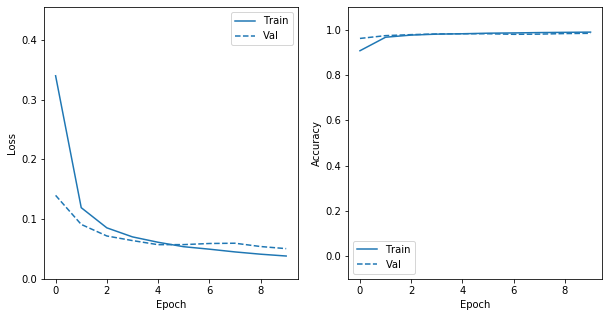

In [33]:
plot_metrics(model3_history)

In [34]:
loss, acc = model3.evaluate(x_test, y_test, verbose=0)
print('Accuracy: %.3f' % acc)

Accuracy: 0.984


In [35]:
print_res(model3)

7 2 1 0 4 1 4 9 6 9 
0 6 9 0 1 5 9 7 8 4 
9 6 6 5 4 0 7 4 0 1 
3 1 3 4 7 2 7 1 2 1 
1 7 4 2 3 5 1 2 4 4 
6 3 5 5 6 0 4 1 9 5 
7 8 9 3 7 4 6 4 3 0 
7 0 2 9 1 7 3 2 9 7 
7 6 2 7 8 4 7 3 6 1 
3 6 4 3 1 4 1 7 6 9 
--
7 2 1 0 4 1 4 9 5 9 
0 6 9 0 1 5 9 7 3 4 
9 6 6 5 4 0 7 4 0 1 
3 1 3 4 7 2 7 1 2 1 
1 7 4 2 3 5 1 2 4 4 
6 3 5 5 6 0 4 1 9 5 
7 8 9 3 7 4 6 4 3 0 
7 0 2 9 1 7 3 2 9 7 
7 6 2 7 8 4 7 3 6 1 
3 6 9 3 1 4 1 7 6 9 


3

The accuracy goes up and there are only 3 mistatakes in the first 100 images.

## Adding another dense (hidden) layer

In [36]:
model4 = make_model(32,3,2,True)
model4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               540900    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 542,230
Trainable params: 542,230
Non-trainable params: 0
________________________________________________

This lets the number of parameters grow to over half a million!
We train this final CNN model.

In [37]:
model4_history = model4.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE)

Epoch 1/10
469/469 [==============================] - 11s 22ms/step - loss: 0.6402 - accuracy: 0.8062 - val_loss: 0.0987 - val_accuracy: 0.9699
Epoch 2/10
469/469 [==============================] - 11s 23ms/step - loss: 0.1550 - accuracy: 0.9555 - val_loss: 0.0624 - val_accuracy: 0.9801
Epoch 3/10
469/469 [==============================] - 12s 26ms/step - loss: 0.1095 - accuracy: 0.9688 - val_loss: 0.0551 - val_accuracy: 0.9814
Epoch 4/10
469/469 [==============================] - 12s 25ms/step - loss: 0.0876 - accuracy: 0.9734 - val_loss: 0.0459 - val_accuracy: 0.9839
Epoch 5/10
469/469 [==============================] - 12s 26ms/step - loss: 0.0715 - accuracy: 0.9793 - val_loss: 0.0465 - val_accuracy: 0.9840
Epoch 6/10
469/469 [==============================] - 12s 26ms/step - loss: 0.0644 - accuracy: 0.9801 - val_loss: 0.0441 - val_accuracy: 0.9836
Epoch 7/10
469/469 [==============================] - 13s 27ms/step - loss: 0.0579 - accuracy: 0.9820 - val_loss: 0.0399 - val_accuracy:

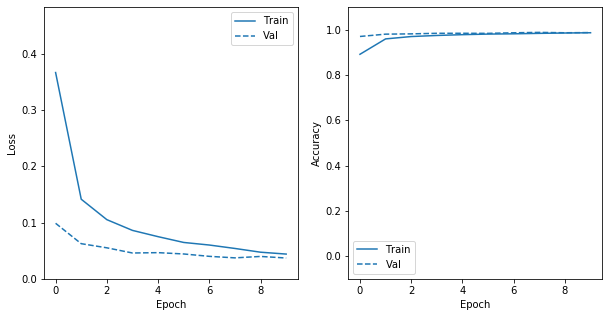

In [38]:
plot_metrics(model4_history)

In [40]:
loss, acc = model4.evaluate(x_test, y_test, verbose=0)
print('Accuracy: %.3f' % acc)

Accuracy: 0.987


In [41]:
 err = print_res(model4)

7 2 1 0 4 1 4 9 5 9 
0 6 9 0 1 5 9 7 5 4 
9 6 6 5 4 0 7 4 0 1 
3 1 3 4 7 2 7 1 2 1 
1 7 4 2 3 5 1 2 4 4 
6 3 5 5 6 0 4 1 9 5 
7 8 9 3 7 4 6 4 3 0 
7 0 2 9 1 7 3 2 9 7 
7 6 2 7 8 4 7 3 6 1 
3 6 4 3 1 4 1 7 6 9 
--
7 2 1 0 4 1 4 9 5 9 
0 6 9 0 1 5 9 7 3 4 
9 6 6 5 4 0 7 4 0 1 
3 1 3 4 7 2 7 1 2 1 
1 7 4 2 3 5 1 2 4 4 
6 3 5 5 6 0 4 1 9 5 
7 8 9 3 7 4 6 4 3 0 
7 0 2 9 1 7 3 2 9 7 
7 6 2 7 8 4 7 3 6 1 
3 6 9 3 1 4 1 7 6 9 


The accuracy goes up a bit and there are {{err}} mistatake left in the first 100 images.